In [21]:
# PAIRWISE CLASSIFICATION EXAMPLE
# BFgam VS CMgam
# 28/07/2019
require(compiler)
require(RcppNumerical)
setMKLthreads(20)
#setwd()

In [2]:
# FOR SIMPLICITY I JUST USE THE SAME SNPs AS IN THE 13-POPULATION CLASSIFICATION
load('Haplotype_16Filtered.RData')
ls()

[1] "haplotype" "label"     "POS"

In [3]:
# JUST SOME FUNCTIONS
fsum<-function(x) {.Primitive('sum')(x)}
gc2<-function() {invisible(gc())}

In [4]:
# CHOOSE THE TWO TARGETED POPULATIONS
pop1<-'BFgam'
pop2<-'CMgam'
haplotype1<-haplotype[label==pop1,]
haplotype2<-haplotype[label==pop2,]
dim(haplotype1)
dim(haplotype2)
rm(haplotype); gc2(); 

[1]    184 117461

[1]    594 117461

In [5]:
# FILTER MAF ON THE COMBINED POPULATION. RETAIN THE ALLELE FREQ (freq) VECTOR
mode(haplotype1)<-'numeric'
mode(haplotype2)<-'numeric'
freq<-apply(rbind(haplotype1, haplotype2), 2, fsum)/(nrow(haplotype1)+nrow(haplotype2))
maf<-freq
maf[maf>0.5]<-1-maf[maf>0.5]

In [6]:
# SELECT LOCI WITH MAF>5%?
s<-(maf>=0.05)
sum(s)
#plot(maf1, maf2)
haplotype1<-haplotype1[,s]
haplotype2<-haplotype2[,s]
freq<-freq[s]
POS<-POS[s]
dim(haplotype1)
dim(haplotype2)
length(POS)
rm(maf); rm(s); gc2(); 
# 107195 LOCI REMAINING

[1] 107195

[1]    184 107195

[1]    594 107195

[1] 107195

In [7]:
# I DON'T THINK I NEED ANOTHER ROUND OF LD PRUNNING. 
# NOW LOOK AT PRIVATE ALLELES OUT OF THESE 107195 LOCI?
freq1<-apply(haplotype1, 2, fsum)/nrow(haplotype1)
freq2<-apply(haplotype2, 2, fsum)/nrow(haplotype2)

sum(freq1==0 & freq2>0)
sum(freq1==1 & freq1<1)
sum(freq2==0 & freq1>0)
sum(freq2==1 & freq1<1)
rm(freq1); rm(freq2); gc2(); 
# SO THE CONCLUSION IS THAT THERE AREN'T TOO MANY PRIVATE ALLELES IN THIS EXAMPLE

[1] 1

[1] 0

[1] 0

[1] 0

In [8]:
# CREATE GENOTYPE DATASETS AND POPULATION LABELS
odd<-seq(1, nrow(haplotype1), 2)
even<-seq(2, nrow(haplotype1), 2)
genotype1<-haplotype1[odd,]+haplotype2[even,]
rm(odd); rm(even);
odd<-seq(1, nrow(haplotype2), 2)
even<-seq(2, nrow(haplotype2), 2)
genotype2<-haplotype2[odd,]+haplotype2[even,]
rm(odd); rm(even);
dim(genotype1)
dim(genotype2)
genotype_both<-rbind(genotype1, genotype2)
label1<-rep(pop1, nrow(genotype1))
label2<-rep(pop2, nrow(genotype2))
label_both<-c(label1, label2)
col1<-rep(1, nrow(genotype1))
col2<-rep(2, nrow(genotype2))
col_both<-c(col1, col2)
gc2();

[1]     92 107195

[1]    297 107195

In [10]:
# SUPERVISED LEARNING
# THE PLAN IS USE LOGISTIC REGRESSION AS THE CLASSIFIER
# BUT THE FIRST STEP IS ALWATS TO SPLIT INTO TRAINING AND TESTING SET. 80:20, STRATIFIED. 
set.seed(12345)
s<-sample(nrow(genotype1), size=round(0.8*nrow(genotype1)))
train_genotype1<-genotype1[s,]
test_genotype1<-genotype1[-s,]
train_label1<-label1[s]
test_label1<-label1[-s]
train_col1<-col1[s]
test_col1<-col1[-s]
rm(s)
s<-sample(nrow(genotype2), size=round(0.8*nrow(genotype2)))
train_genotype2<-genotype2[s,]
test_genotype2<-genotype2[-s,]
train_label2<-label2[s]
test_label2<-label2[-s]
train_col2<-col2[s]
test_col2<-col2[-s]
rm(s)
# COMBINE
train_genotype<-rbind(train_genotype1, train_genotype2)
train_label<-c(train_label1, train_label2)
train_col<-c(train_col1, train_col2)
test_genotype<-rbind(test_genotype1, test_genotype2)
test_label<-c(test_label1, test_label2)
test_col<-c(test_col1, test_col2)

In [11]:
# CHECK DIMINSIONS (OPTIONAL, JUST FOR ERROR CHECKING)
#dim(train_genotype)
#length(train_label)
#length(train_col)
#dim(test_genotype)
#length(test_label)
#length(test_col)

In [12]:
# 1) LOGISTIC REGRESSION ON THE RAW GENOTYPE. WILL IT WORK?
#m<-glm(train_label~train_genotype, family='binomial')

In [29]:
# THE PLAIN VANILLA glm() IS TOO SLOW
# TRY USING fastLR() FROM RcppNumerical PACKAGE
# y IS THE NUMERIC VERSION OF train_label. 0=pop1, 1=pop2
y<-as.numeric(train_label==pop2)
system.time(m<-fastLR(y=y, x=train_genotype, maxit=1000))
# THE MAXIMISED LOG-LIKELIHOOD VALUE
m$loglikelihood

   user  system elapsed 
   3.68    0.00    3.69 

[1] -4.238318e-07

In [35]:
# TO SEE THE FITTED VALUES OF THE TRAIN SET
# temp IS THE LINEAR PREDICTOR. IF temp<0 IT IS pop1=BFgam
temp<-train_genotype%*%m$coefficients
data.frame(linear_predictor=temp, train_label=train_label)

linear_predictor,train_label
-23.16115,BFgam
-24.62318,BFgam
-37.44539,BFgam
-19.66619,BFgam
-21.34424,BFgam
-20.46904,BFgam
-33.03828,BFgam
-19.97020,BFgam
-22.89617,BFgam
-19.34783,BFgam


In [36]:
# HOW ABOUT FITTING TO THE TEST SET?
# IT DOESN'T SEEM TO WORK AT ALL
# OVERFITTING???
temp<-test_genotype%*%m$coefficients
data.frame(linear_predictor=temp, test_label=test_label)

linear_predictor,test_label
32.7606433,BFgam
18.9777854,BFgam
30.6749041,BFgam
34.5459421,BFgam
21.7344473,BFgam
33.1786939,BFgam
31.0772465,BFgam
24.4533526,BFgam
29.0503038,BFgam
21.3667515,BFgam


IGNORE THE THINGS BELOW
29/07/2019



POS,coef
34841837,-0.06120580
30493816,0.05098087
10671913,0.04793063
6947514,-0.04740008
29147463,0.04713984
14450548,0.04665493
7278547,0.04612495
26580211,-0.04561867
31626039,0.04488609
16135172,0.04480461


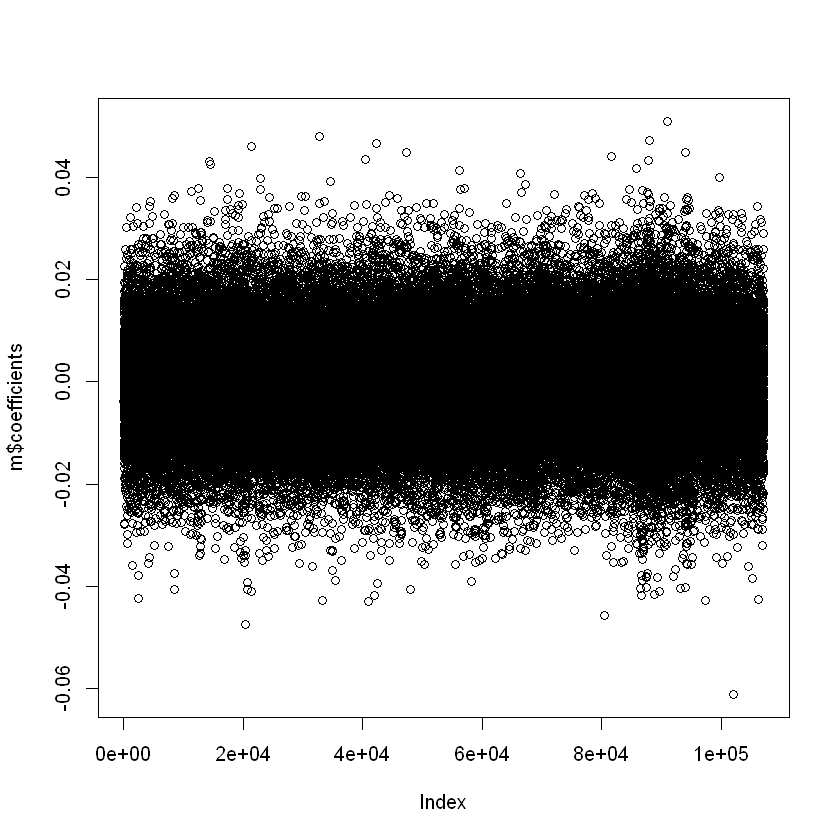

In [17]:
# SNPs CONTRIBUTION?
plot(m$coefficients)
contribution_order<-order(abs(m$coefficients), decreasing=T)
data.frame(POS=POS[contribution_order[1:10]], coef=m$coefficients[contribution_order[1:10]])

In [31]:
# THE PLAIN VANILLA glm() IS TOO SLOW
# TRY WRITING MY OWN LOGISTIC LOG-LIKELIHOOD FUNCTION INVERSE
# RETURNING 1/LOG_LIKE. THEN MINIMISE IT. 
# parm IS A VECTOR OF PARAMETERS WITH LENGTH EQUALS LOCI NUMBER
# y IS THE RESPONSE, OR THE CLASS LABELS (VECTOR), 0=pop1, 1=pop2
y<-as.numeric(train_label==pop2)
log.like.inv<-function(parms)
{
    temp<-train_genotype%*%parms
    temp1<-exp(temp)
    p<-temp1/(1+temp1)
    l<-y*log(p)+(1-y)*log(1-p)
    # REMOVE TOO SMALL PROB
    l2<-l[!is.na(l)]
    return(1/fsum(l2))
}
log.like.inv<-cmpfun(log.like.inv)

# TRY 
log.like.inv(rep(0, 107195))
system.time(log.like.inv(rep(0, 107195)))
# ELAPSE TIME 0.06, TOTAL CPU TIME 1.25s ACROSS 20 CORES. PERFECT SCALING...?
# THE EVALUATION OF THE LOG-LIKE INVOLVES A MATRIX MULTIPLICATION. 
# A GOOD LINPACK DOES THE JOB

[1] -0.004624023

   user  system elapsed 
   1.25    0.00    0.06 

In [34]:
# IF WE EVALUATE THE FUNCTION AT THE SAME POINT WE SHOULD GET THE SAME LOG-LIKE VALUE
1/log.like.inv(m$coefficients)
# YAY!!!

[1] -4.238334e-07

In [12]:
# REPEAT PATTERSON'S NORMALISATION BUT ONLY ON THE TRAINING SET
train_freq<-apply(train_genotype, 2, fsum)/(2*nrow(train_genotype))
train_freq2<-matrix(train_freq, nc=ncol(train_genotype), nr=nrow(train_genotype), byrow=T)
normal_train_genotype<-(train_genotype-2*train_freq2)/sqrt(train_freq2*(1-train_freq2))
rm(train_freq2); gc2(); 

In [13]:
# PCA VIA prccmp(). USE FIRST n=50 COMPONENTS
system.time(e<-prcomp(normal_train_genotype))
n<-50
train_feature<-normal_train_genotype%*%e$rotation[,1:n]
dim(train_feature)

   user  system elapsed 
  19.91    0.63    2.67 

[1] 312  50

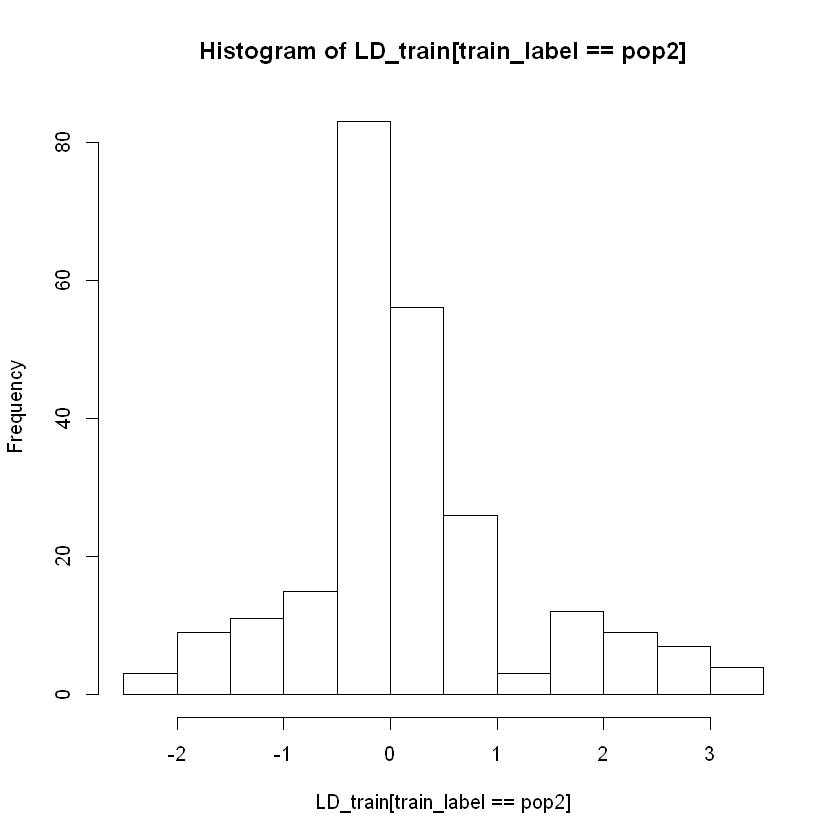

In [17]:
# LDA, AND EXTRACT THE ONLY LD COMPONENT
m_lda<-lda(train_feature, grouping=train_label, prior=c(0.5, 0.5))
LD_train<-train_feature%*%m_lda$scaling

[1] 50  1

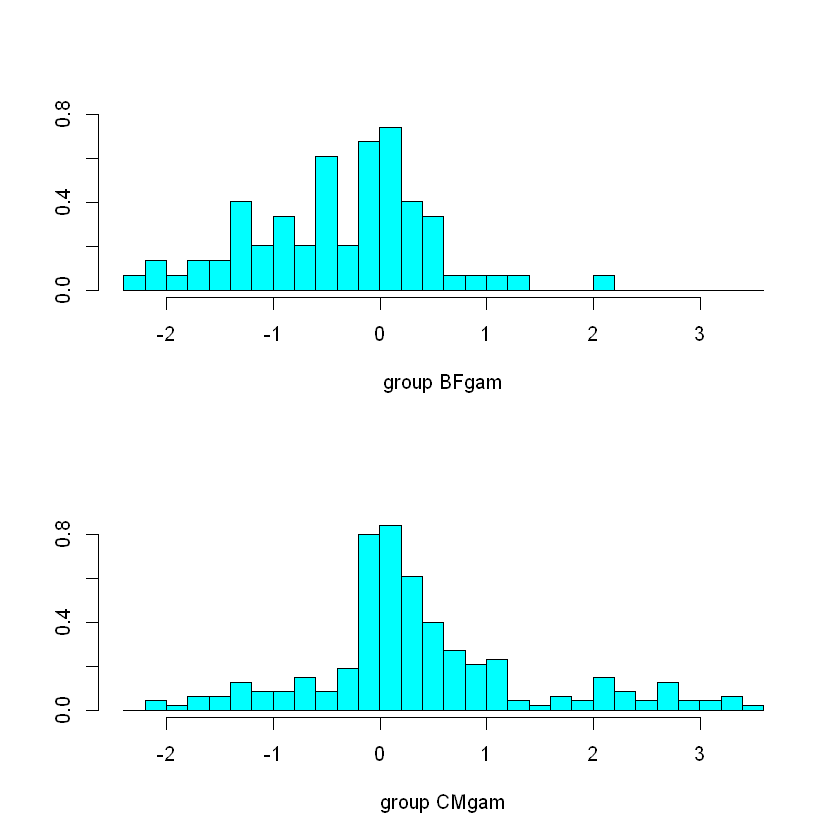

In [15]:
# OR SIMPLE PLOT IT OUT
plot(m_lda)

In [19]:
# NOW TURN TO THE TEST SET. FIRST NORMALISE IT VIA THE SAME PATTERSON FORMULA AND allele_freq
# THEN CREATE test_feature USING THE SAME PCA ROTATION
test_freq2<-matrix(train_freq, nc=ncol(test_genotype), nr=nrow(test_genotype), byrow=T)
normal_test_genotype<-(test_genotype-2*test_freq2)/sqrt(test_freq2*(1-test_freq2))
test_feature<-normal_test_genotype%*%e$rotation[,1:n]
dim(test_feature)
rm(train_freq); rm(test_freq2); invisible(gc());
# PREDICT THE CLASSES GIVEN THE TESTING FEATURES VIA THE EXISTING LDA MODEL. 
result_lda<-predict(m_lda, test_feature)$class
result_lda<-as.character(result_lda)
LD_test<-test_feature%*%m_lda$scaling
# ACCURACY
sum(result_lda==test_label)/length(test_label)

[1] 77 50

[1] 0.7272727

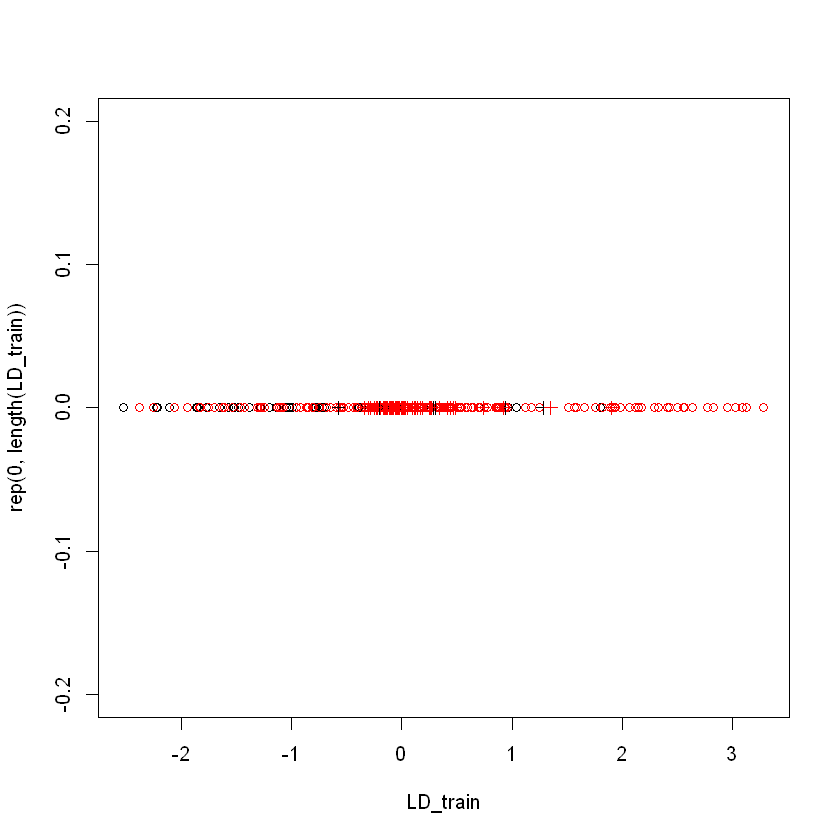

In [20]:
plot(LD_train, rep(0, length(LD_train)), col=train_col, ylim=c(-0.2, 0.2))
points(LD_test, rep(0, length(LD_test)), col=test_col, pch=3)

In [21]:
# HOW ABOUT USING LOGISTIC REGRESSION AS OUR CLASSIFIER? USE muiltinom() FROM PACKAGE nnet. 
# BUT WE NEED TO PUT train_label AND train_feature INTO A DATA FRAME. STUBBORN. 
# AND, NOT SURE IF I UNDERSTAND THE OUTPUTS FROM multinom(). 
train_df<-data.frame(train_label=train_label, train_feature=train_feature)
m_lr<-multinom(train_label~., data=train_df)

# weights:  52 (51 variable)
initial  value 216.261920 
iter  10 value 160.040778
iter  20 value 152.305255
iter  30 value 150.485107
iter  40 value 148.939593
iter  50 value 147.832421
iter  60 value 147.105045
iter  70 value 146.625598
final  value 146.621689 
converged


In [22]:
# PREDICT WITH OUT TEST SET. AGAIN I NEED TO CREATE A DATA FRAME. 
test_df<-data.frame(test_feature=test_feature)
# TO AVOID ERRORS I NEED TO SET THE COLUMN NAMES OF test_df TO MATCH THOSE OF train_df. VERY STUBBORN. 
names(test_df)<-names(train_df)[-1]
# PUT THE test_df TO TEST THE ALGORITHM
result_lr<-predict(m_lr, test_df, type='class')
result_lr<-as.character(result_lr)
# ACCURACY. SHOULD BE AROUND 90%
sum(result_lr==test_label)/length(test_label)

[1] 0.7662338

ERROR: Error in xy.coords(x, y, xlabel, ylabel, log): 'x' is a list, but does not have components 'x' and 'y'
